In [21]:
import warnings
import math
import pandas as pd
import numpy as np
from dbfread import DBF
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    RandomizedSearchCV,
)
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import xgboost as xgb
import shap
from sklearn.inspection import PartialDependenceDisplay

### Load data

In [22]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

df = df.drop(columns=['inidoy', 'enddoy', 'ros_p_lg1'])

for col in df:
    print(col)

Loading dataset...
Dataset loaded
ros_p
duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_s_9_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
CBH_m_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
Cin_av
BLH_m_av
BLH_m_rt
LCL_hPa_av
LCL_m_av
LFC_hPa_av
CCL_hPa_av
EL_m_av
LiftIdx_av
VentIdx_av
CMLG_av
f_start
geometry


In [23]:
nan_percent = df.isna().mean() * 100

# Imprime a % de NaNs por coluna
for col, perc in nan_percent.items():
    print(f"Coluna '{col}': {perc:.2f}% de NaNs")

df = df.loc[:, nan_percent <= 10]

for col in df:
    print(col)

Coluna 'ros_p': 0.34% de NaNs
Coluna 'duration_p': 0.00% de NaNs
Coluna 'elev_av': 0.00% de NaNs
Coluna 'aspect_av': 0.00% de NaNs
Coluna 'landform': 0.08% de NaNs
Coluna 'land_use': 9.43% de NaNs
Coluna '1_3y_fir_p': 0.00% de NaNs
Coluna '3_8y_fir_p': 0.00% de NaNs
Coluna '8_ny_fir_p': 0.00% de NaNs
Coluna 'fuel_model': 0.00% de NaNs
Coluna 'f_load_av': 0.00% de NaNs
Coluna 'sW_1m_av': 0.00% de NaNs
Coluna 'sW_3m_av': 0.00% de NaNs
Coluna 'sW_7_av': 0.00% de NaNs
Coluna 'sW_28_av': 0.00% de NaNs
Coluna 'sW_100_av': 0.00% de NaNs
Coluna 'sW_289_av': 0.00% de NaNs
Coluna 't_2m_C_av': 0.00% de NaNs
Coluna 'd_2m_C_av': 0.00% de NaNs
Coluna 'rh_2m_av': 0.00% de NaNs
Coluna 'VPD_Pa_av': 0.00% de NaNs
Coluna 'sP_hPa_av': 0.00% de NaNs
Coluna 'gp_m2s2_av': 0.00% de NaNs
Coluna 'dfmc_av': 0.00% de NaNs
Coluna 'HDW_av': 0.00% de NaNs
Coluna 'Haines_av': 0.00% de NaNs
Coluna 'FWI_12h_av': 0.00% de NaNs
Coluna 'DC_12h_av': 0.00% de NaNs
Coluna 'FFMC_12h_a': 0.00% de NaNs
Coluna 'wv10_kh_av': 0.00

### convert categorical variables into "category" type

In [24]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### create log vars

In [25]:
import numpy as np
import pandas as pd

# Seleciona colunas que NÃO são categóricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Cria novas variáveis com log natural
for col in num_cols:
    df[f'{col}_log'] = np.sign(df[col]) * np.log(np.abs(df[col]) + 1)

df = df.drop(columns=['ros_p'])

for col in df.columns:
    print(col)

duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
BLH_m_av
BLH_m_rt
LCL_hPa_av
LCL_m_av
CCL_hPa_av
LiftIdx_av
VentIdx_av
CMLG_av
f_start
geometry
ros_p_log
duration_p_log
elev_av_log
aspect_av_log
1_3y_fir_p_log
3_8y_fir_p_log
8_ny_fir_p_log


### remove nans from ros_p

In [26]:
n_before = len(df)
df = df.dropna(subset=['ros_p_log']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 4 rows with NaN in 'ros_p'. Remaining rows: 1173


### train and test datasets

In [27]:
# Define features (excluding specific columns)

train_features = [col for col in df.columns if col not in ('ros_p_log', 'inidoy', 'enddoy', "geometry")]
# Create initial X and y
X = df[train_features].copy()
y = df['ros_p_log'].copy()


# Remove invalid targets (-1) BEFORE cross-validation 

valid_mask = y != -1
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)

print(f"Total valid samples for Cross-Validation: {len(X)}")

Total valid samples for Cross-Validation: 1173


### ALL VARS MODELLING

In [28]:
# ============================================================
# CONFIGURAÇÃO INICIAL
# ============================================================
import numpy as np
import pandas as pd
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*100)
print("🚀 REGRESSÃO LINEAR + REPEATED CV + IMPORTÂNCIA DAS FEATURES")
print("="*100)

# ============================================================
# DADOS
# ============================================================

print(f"📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")
print("   ✔ Target já está log-transformada.")

# ============================================================
# PIPELINE
# ============================================================
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

# ============================================================
# REPEATED CROSS VALIDATION
# ============================================================
print("\n🔄 Repeated K-Fold Cross Validation (10 folds × 10 repeats)")
print("="*100)

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

cv_results = []
start = time.time()

for fold, (train_idx, test_idx) in enumerate(rkf.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    cv_results.append([r2, rmse, mae])

elapsed = time.time() - start

cv_results = np.array(cv_results)
mean_r2, std_r2 = cv_results[:,0].mean(), cv_results[:,0].std()
mean_rmse, std_rmse = cv_results[:,1].mean(), cv_results[:,1].std()
mean_mae, std_mae = cv_results[:,2].mean(), cv_results[:,2].std()

print(f"📈 R²:   {mean_r2:.4f} ± {std_r2:.4f}")
print(f"📉 RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"📉 MAE:  {mean_mae:.4f} ± {std_mae:.4f}")
print(f"\n⏱ Tempo total: {elapsed:.1f} segundos")

# ============================================================
# TREINO FINAL NO CONJUNTO COMPLETO
# ============================================================
print("\n🎯 Treinando modelo final com todos os dados")
print("="*100)

final_model = pipeline.fit(X, y)
coef = final_model.named_steps["linreg"].coef_

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": coef,
    "importance": np.abs(coef)
}).sort_values("importance", ascending=False)

print("Top 10 variáveis mais importantes:")
print(coef_df.head(10))


🚀 REGRESSÃO LINEAR + REPEATED CV + IMPORTÂNCIA DAS FEATURES
📊 X shape: (1173, 176)
📊 y shape: (1173,)
   ✔ Target já está log-transformada.

🔄 Repeated K-Fold Cross Validation (10 folds × 10 repeats)


📈 R²:   0.4873 ± 0.0686
📉 RMSE: 0.7745 ± 0.0413
📉 MAE:  0.6073 ± 0.0230

⏱ Tempo total: 1.8 segundos

🎯 Treinando modelo final com todos os dados
Top 10 variáveis mais importantes:
            feature       coef  importance
97     sW_1m_av_log  88.103476   88.103476
101   sW_100_av_log -54.530039   54.530039
63        gp_300_av  28.979876   28.979876
100    sW_28_av_log -28.843348   28.843348
149   gp_300_av_log -27.959622   27.959622
169  LCL_hPa_av_log  26.185668   26.185668
98     sW_3m_av_log -24.548930   24.548930
62        gp_500_av -19.940559   19.940559
148   gp_500_av_log  19.702266   19.702266
61        gp_700_av -19.596289   19.596289



🔍 Forward Feature Selection rápido usando AIC (sem repetir linear/log)

➡ Iteração #1 – 1/176 features


   ✔ Variável adicionada: duration_p
   ⭐ AIC = -32.724, R² = 0.1833, MAE linear = 611.3708

➡ Iteração #2 – 2/176 features
   ✔ Variável adicionada: DC_12h_av_log
   ⭐ AIC = -239.673, R² = 0.3165, MAE linear = 555.2563

➡ Iteração #3 – 3/176 features
   ✔ Variável adicionada: HDW_av_log
   ⭐ AIC = -350.223, R² = 0.3791, MAE linear = 536.3077

➡ Iteração #4 – 4/176 features
   ✔ Variável adicionada: 3_8y_fir_p_log
   ⭐ AIC = -396.882, R² = 0.4043, MAE linear = 526.4875

➡ Iteração #5 – 5/176 features
   ✔ Variável adicionada: gT_8_7_av
   ⭐ AIC = -423.258, R² = 0.4185, MAE linear = 514.4671

➡ Iteração #6 – 6/176 features
   ✔ Variável adicionada: Cape_av_log
   ⭐ AIC = -465.655, R² = 0.4401, MAE linear = 505.4546

➡ Iteração #7 – 7/176 features
   ✔ Variável adicionada: wv_850_av
   ⭐ AIC = -482.103, R² = 0.4489, MAE linear = 496.0519

➡ Iteração #8 – 8/176 features
   ✔ Variável adicionada: wdi_950_av
   ⭐ AIC = -503.733, R² = 0.4599, MAE linear = 494.6207

➡ Iteração #9 – 9/176 feat

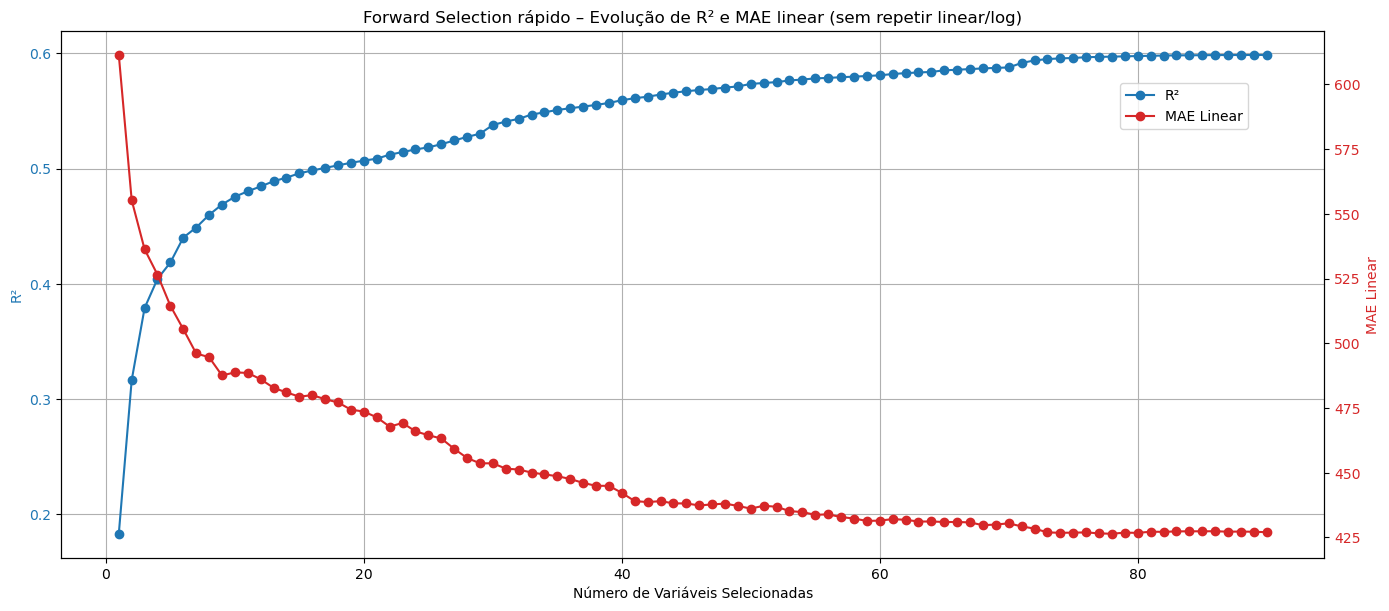

In [29]:
# ============================================================
# FORWARD FEATURE SELECTION RÁPIDO (AIC, todas as variáveis, sem repetir linear/log)
# ============================================================
print("\n🔍 Forward Feature Selection rápido usando AIC (sem repetir linear/log)")
print("="*100)

features = list(X.columns)
selected_features = []
remaining_features = features.copy()
results = []

iteration = 1

while len(remaining_features) > 0:

    best_aic = np.inf
    best_feature = None

    print(f"\n➡ Iteração #{iteration} – {len(selected_features)+1}/{len(features)} features")

    # testar adicionar cada variável ainda não selecionada
    for f in remaining_features:
        test_features = selected_features + [f]

        # treinar modelo no conjunto completo
        model = pipeline.fit(X[test_features], y)
        y_pred = model.predict(X[test_features])

        mse = mean_squared_error(y, y_pred)
        n = len(y)
        p = len(test_features) + 1  # +1 intercepto
        aic = n * np.log(mse) + 2 * p

        if aic < best_aic:
            best_aic = aic
            best_feature = f

    # adicionar feature escolhida
    selected_features.append(best_feature)

    # remover feature selecionada da lista
    remaining_features.remove(best_feature)

    # remover a versão “oposta” (linear/log) da mesma variável
    if best_feature.endswith("_log"):
        alt_var = best_feature.replace("_log", "")
    else:
        alt_var = best_feature + "_log"
    if alt_var in remaining_features:
        remaining_features.remove(alt_var)

    # calcular R² e MAE linear
    model = pipeline.fit(X[selected_features], y)
    y_pred = model.predict(X[selected_features])

    r2 = r2_score(y, y_pred)
    mae_linear = np.mean(np.abs(np.exp(y_pred) - np.exp(y)))

    results.append([iteration, best_feature, r2, mae_linear, best_aic])

    print(f"   ✔ Variável adicionada: {best_feature}")
    print(f"   ⭐ AIC = {best_aic:.3f}, R² = {r2:.4f}, MAE linear = {mae_linear:.4f}")

    iteration += 1

# DataFrame dos resultados
ffs_df = pd.DataFrame(results, columns=["iteration", "added_feature", "R2", "MAE_linear", "AIC"])
ffs_df.to_csv("linear_model_ffs_result.csv", index=False)
print("\n✅ Resultados salvos em 'linear_model_ffs_result.csv'")

# ============================================================
# GRÁFICO COMBINADO DE R² e MAE linear com dois eixos y
# ============================================================
fig, ax1 = plt.subplots(figsize=(14,6))

color_r2 = 'tab:blue'
ax1.set_xlabel("Número de Variáveis Selecionadas")
ax1.set_ylabel("R²", color=color_r2)
ax1.plot(ffs_df["iteration"], ffs_df["R2"], marker="o", color=color_r2, label="R²")
ax1.tick_params(axis='y', labelcolor=color_r2)
ax1.grid(True)

ax2 = ax1.twinx()
color_mae = 'tab:red'
ax2.set_ylabel("MAE Linear", color=color_mae)
ax2.plot(ffs_df["iteration"], ffs_df["MAE_linear"], marker="o", color=color_mae, label="MAE Linear")
ax2.tick_params(axis='y', labelcolor=color_mae)

fig.tight_layout()
plt.title("Forward Selection rápido – Evolução de R² e MAE linear (sem repetir linear/log)")
fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9))
plt.show()



✅ Variáveis selecionadas (6): ['duration_p', 'DC_12h_av_log', 'HDW_av_log', '3_8y_fir_p_log', 'gT_8_7_av', 'Cape_av_log']

Intercept (ln(a)): 6.2374
Coeficientes:
  duration_p: -0.4962
  DC_12h_av_log: 0.3153
  HDW_av_log: 0.2254
  3_8y_fir_p_log: 0.1753
  gT_8_7_av: -0.1931
  Cape_av_log: -0.2022

Equação final do modelo:
ln(ROS) = 6.2374 + -0.4962*duration_p + 0.3153*DC_12h_av_log + 0.2254*HDW_av_log + 0.1753*3_8y_fir_p_log + -0.1931*gT_8_7_av + -0.2022*Cape_av_log

R² (log scale) = 0.4401
MAE (linear scale) = 505.4546


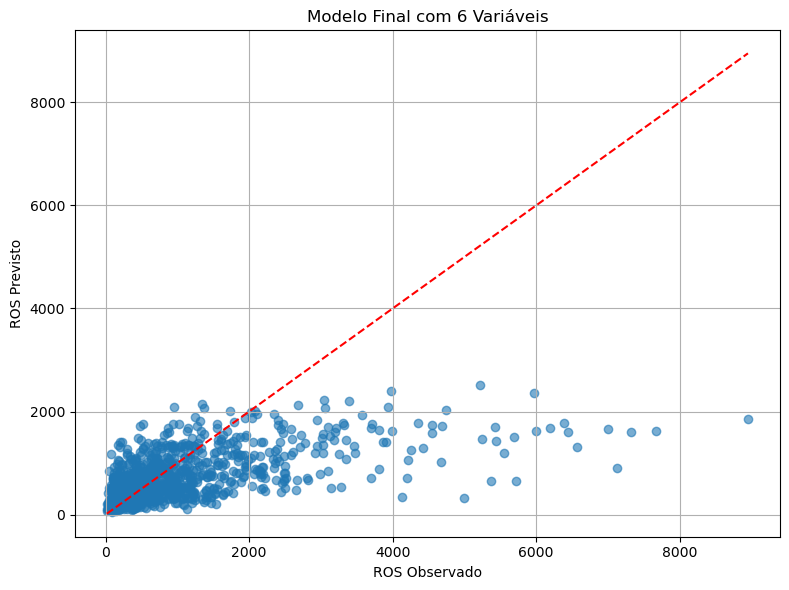


✅ Modelo salvo em '..\..\Data\Models\model_linear_ffs.pkl'


In [30]:
# ============================================================
# MODELO FINAL COM N VARIÁVEIS SELECIONADAS
# ============================================================

import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Definir número de variáveis que quer usar
# ------------------------------------------------------------
n_selected = 6  # altere este valor para o número de variáveis desejado

# pegar as n primeiras variáveis selecionadas pelo FFS
final_features = ffs_df["added_feature"].iloc[:n_selected].tolist()
print(f"\n✅ Variáveis selecionadas ({n_selected}): {final_features}")

# ------------------------------------------------------------
# 2. Treinar modelo final com estas variáveis
# ------------------------------------------------------------
X_final = X[final_features]
y_final = y

final_model = pipeline.fit(X_final, y_final)
y_pred = final_model.predict(X_final)

# ------------------------------------------------------------
# 3. Coeficientes e equação final
# ------------------------------------------------------------
intercept = final_model.named_steps["linreg"].intercept_
coef = final_model.named_steps["linreg"].coef_

print(f"\nIntercept (ln(a)): {intercept:.4f}")
print("Coeficientes:")
for var, c in zip(final_features, coef):
    print(f"  {var}: {c:.4f}")

# Construir a equação em formato legível
equation_terms = [f"{c:.4f}*{var}" for var, c in zip(final_features, coef)]
equation = "ln(ROS) = {:.4f} + ".format(intercept) + " + ".join(equation_terms)
print("\nEquação final do modelo:")
print(equation)

# ------------------------------------------------------------
# 4. Métricas do modelo final
# ------------------------------------------------------------
r2 = r2_score(y_final, y_pred)
mae_linear = np.mean(np.abs(np.exp(y_pred) - np.exp(y_final)))
print(f"\nR² (log scale) = {r2:.4f}")
print(f"MAE (linear scale) = {mae_linear:.4f}")

# ------------------------------------------------------------
# 5. Plot ROS previsto vs observado (linear)
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(np.exp(y_final), np.exp(y_pred), alpha=0.6)
plt.plot([np.exp(y_final).min(), np.exp(y_final).max()],
         [np.exp(y_final).min(), np.exp(y_final).max()], "r--")
plt.xlabel("ROS Observado")
plt.ylabel("ROS Previsto")
plt.title(f"Modelo Final com {n_selected} Variáveis")
plt.grid(True)
plt.tight_layout()
plt.show()

import pickle

# ------------------------------------------------------------
# 6. Salvar modelo final em .pkl
# ------------------------------------------------------------
model_filename = f"..\..\Data\Models\model_linear_ffs.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(final_model, f)

print(f"\n✅ Modelo salvo em '{model_filename}'")


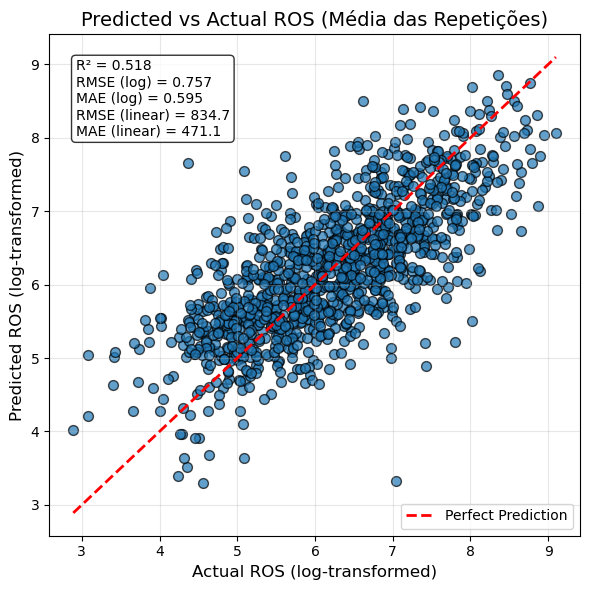

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ============================================================
# 1. Acumular previsões de cada fold para cada observação
# ============================================================
pred_matrix = np.full((len(y), rkf.get_n_splits()), np.nan)

for fold_idx, (train_idx, test_idx) in enumerate(rkf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_pred = pipeline.fit(X_train, y_train).predict(X_test)
    pred_matrix[test_idx, fold_idx] = y_pred

# Média das previsões
avg_pred_log = np.nanmean(pred_matrix, axis=1)
avg_actual_log = y.values

# ============================================================
# 2. Função para reverter log
# ============================================================
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

# ============================================================
# 3. Métricas
# ============================================================
r2_avg = r2_score(avg_actual_log, avg_pred_log)
mae_log_avg = mean_absolute_error(avg_actual_log, avg_pred_log)
rmse_log_avg = np.sqrt(mean_squared_error(avg_actual_log, avg_pred_log))

y_actual_linear = inverse_safe_log(avg_actual_log)
y_pred_linear = inverse_safe_log(avg_pred_log)
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))

# ============================================================
# 4. Scatter plot Predicted vs Actual
# ============================================================
plt.figure(figsize=(6, 6))
plt.scatter(avg_actual_log, avg_pred_log, alpha=0.7, edgecolor='k', s=50)

min_val = min(avg_actual_log.min(), avg_pred_log.min())
max_val = max(avg_actual_log.max(), avg_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Média das Repetições)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f'R² = {r2_avg:.3f}\n'
    f'RMSE (log) = {rmse_log_avg:.3f}\n'
    f'MAE (log) = {mae_log_avg:.3f}\n'
    f'RMSE (linear) = {rmse_linear_avg:.1f}\n'
    f'MAE (linear) = {mae_linear_avg:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


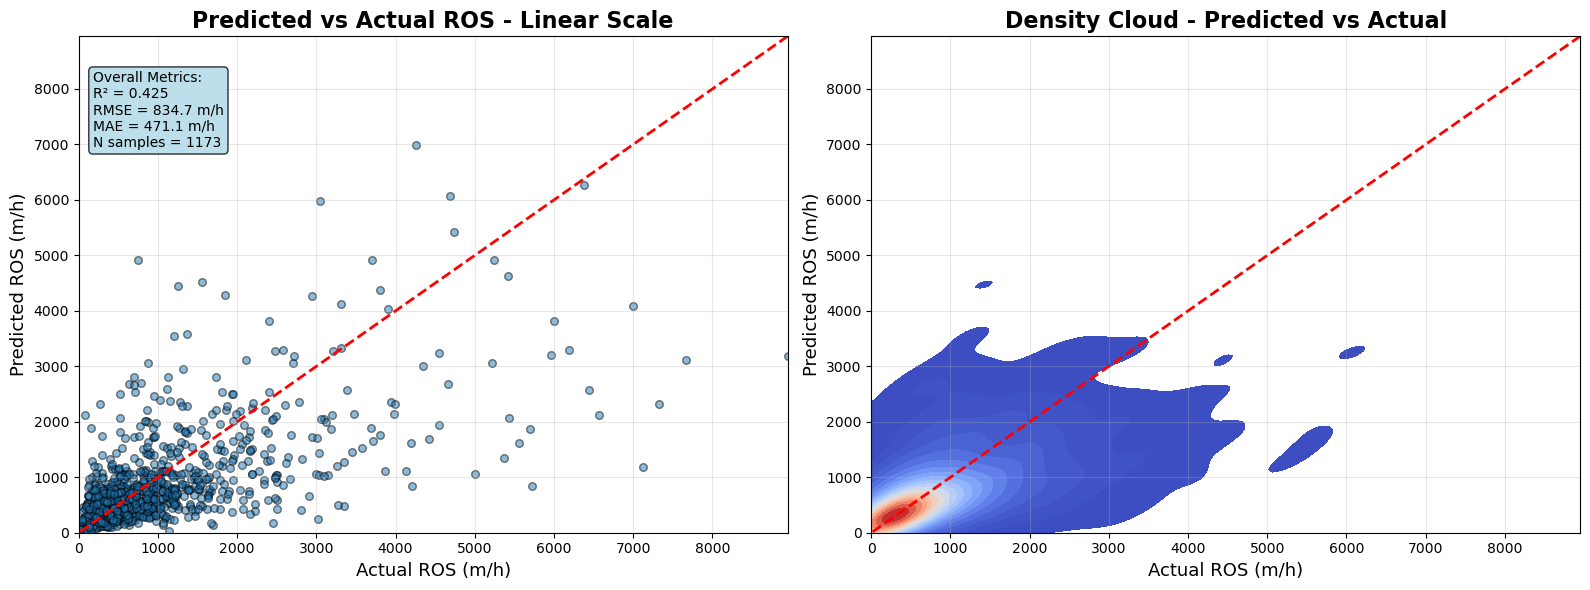

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# 1. Converter de log → linear
# ============================================================
y_actual_linear = inverse_safe_log(avg_actual_log)
y_pred_linear = inverse_safe_log(avg_pred_log)

# ============================================================
# 2. Métricas lineares
# ============================================================
r2_linear = r2_score(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)

# ============================================================
# 3. Scatter + 2D KDE plot
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# -------------------------
# Left panel: Scatter plot
# -------------------------
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

metrics_text = (
    f'Overall Metrics:\n'
    f'R² = {r2_linear:.3f}\n'
    f'RMSE = {rmse_linear_avg:.1f} m/h\n'
    f'MAE = {mae_linear_avg:.1f} m/h\n'
    f'N samples = {len(y_actual_linear)}'
)
ax1.text(
    0.02, 0.93, metrics_text,
    transform=ax1.transAxes, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10
)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# -------------------------
# Right panel: 2D KDE density plot
# -------------------------
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


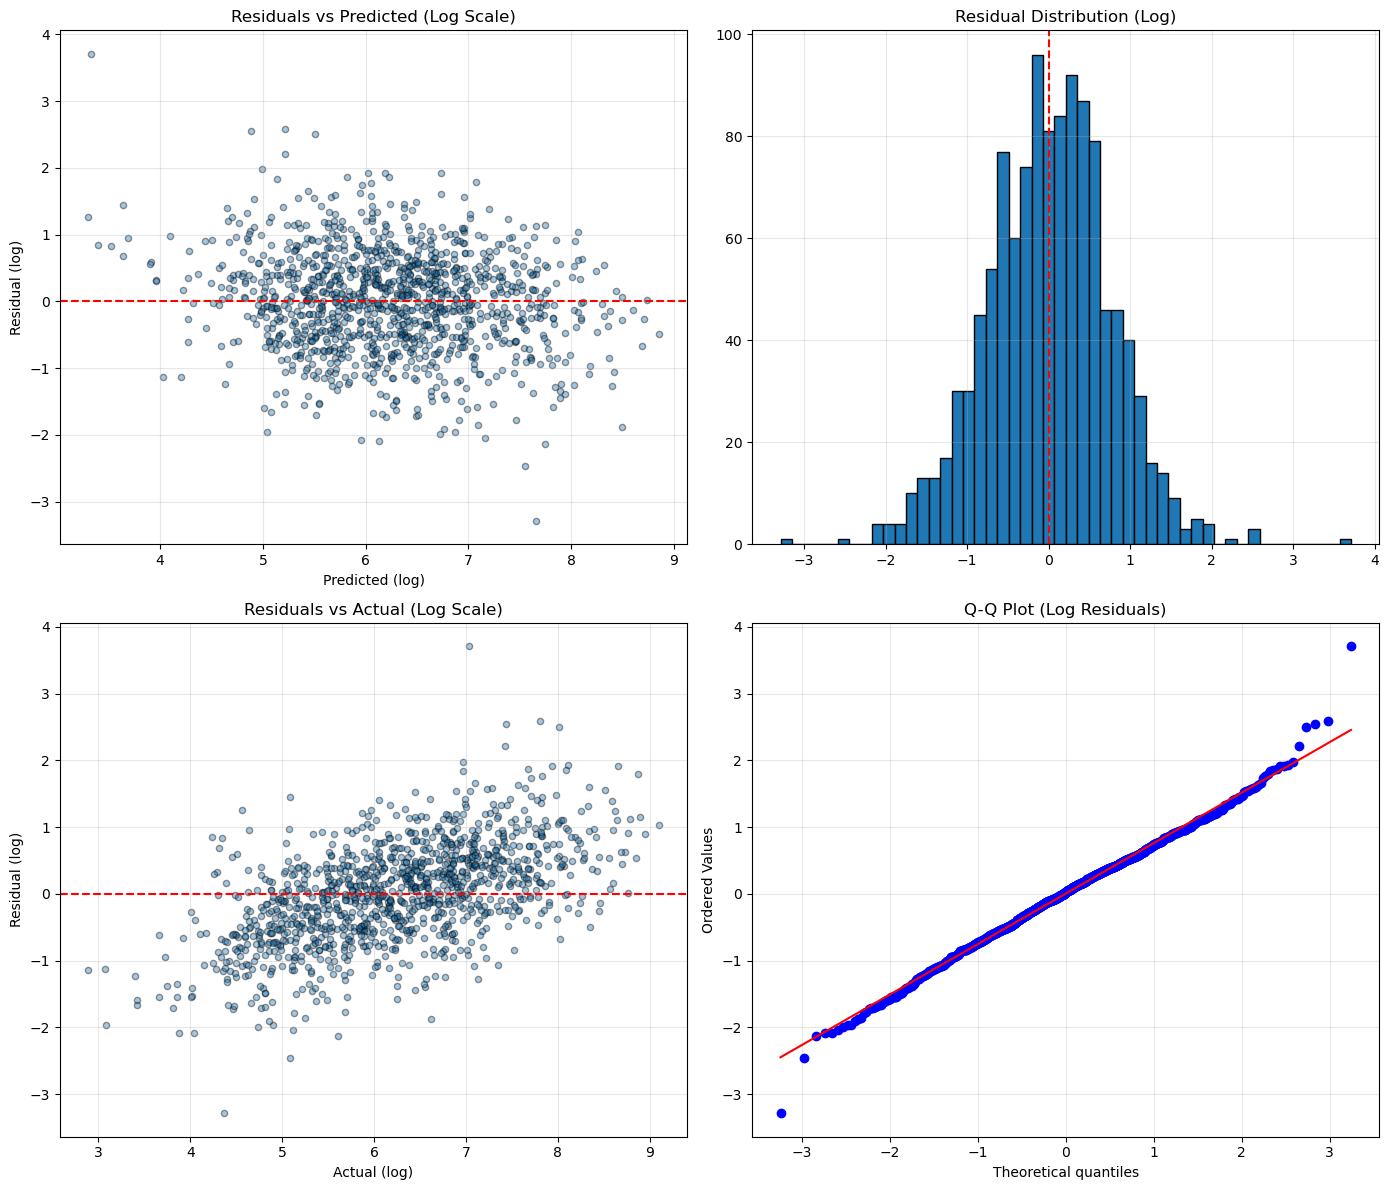

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# ============================================================
# 1. Usar médias do Repeated K-Fold
# ============================================================
avg_actual = avg_actual_log   # valores reais médios (log)
avg_pred   = avg_pred_log     # valores previstos médios (log)

# Conversão para escala linear, se quiser usar depois
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos na escala log
residuals_log = avg_actual - avg_pred

# ============================================================
# 2. Plots de diagnóstico dos resíduos
# ============================================================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------
# Residuals vs Predicted
# -------------------------
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# -------------------------
# Histogram of residuals
# -------------------------
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# -------------------------
# Residuals vs Actual
# -------------------------
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# -------------------------
# Q-Q Plot
# -------------------------
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


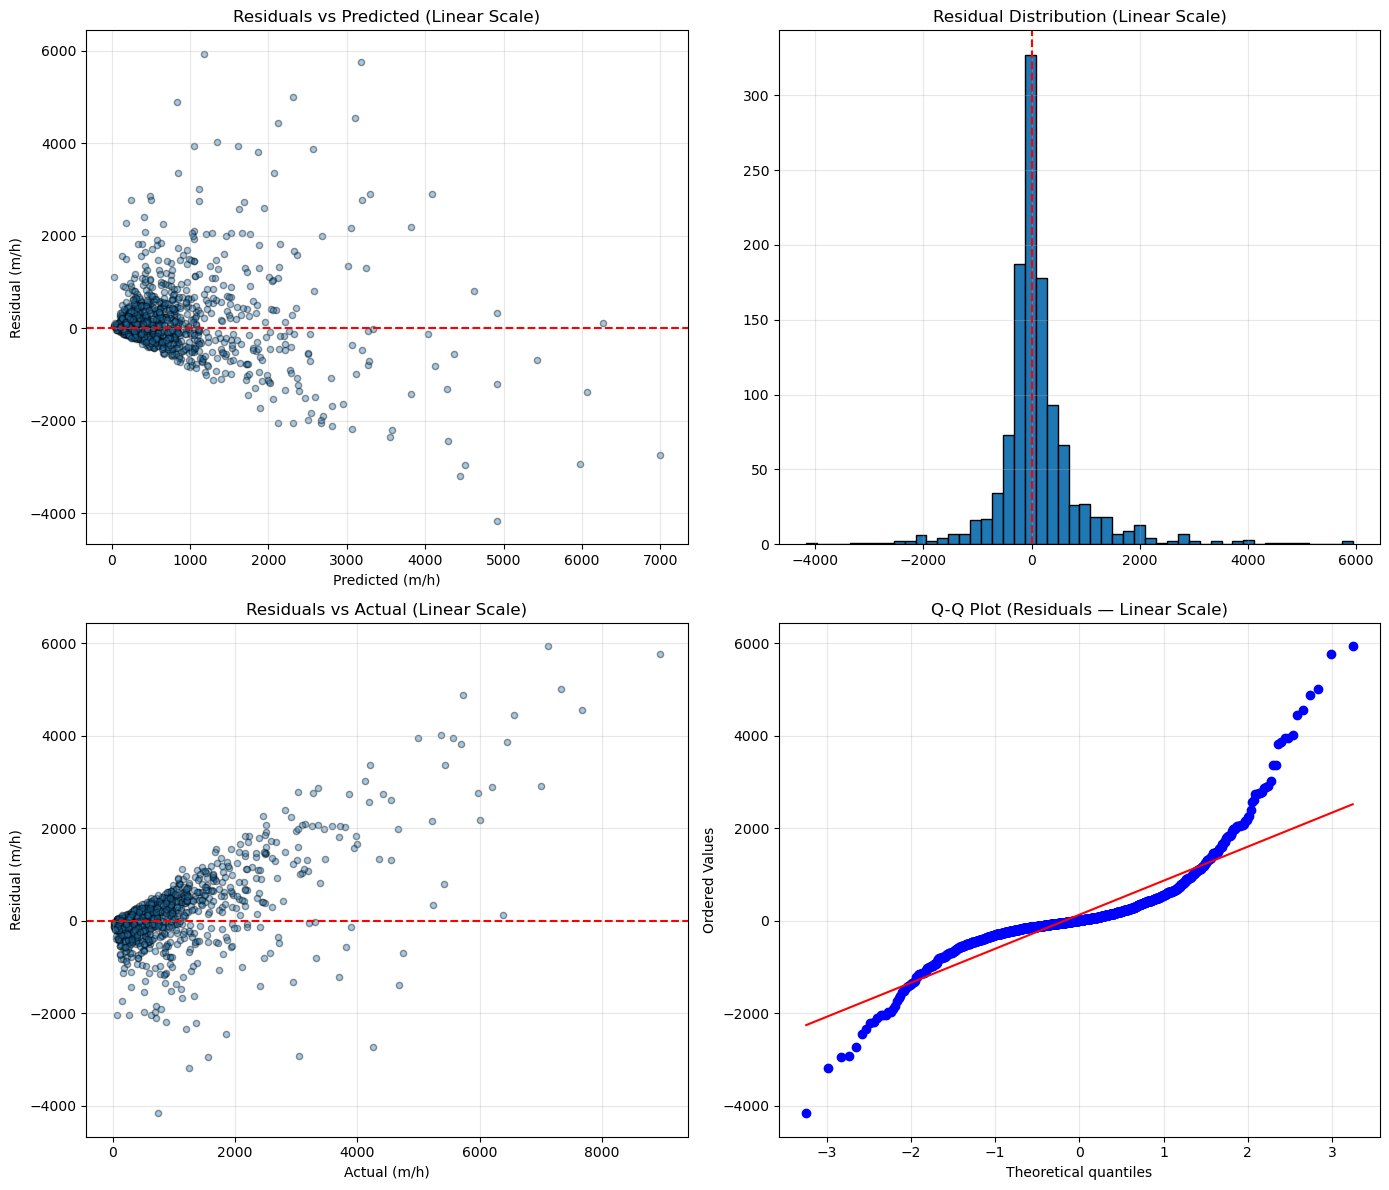

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = avg_actual_log      # já calculado antes
avg_pred_log   = avg_pred_log        # já calculado antes

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 456  (38.9%)
Bad Predictions  : 717  (61.1%)


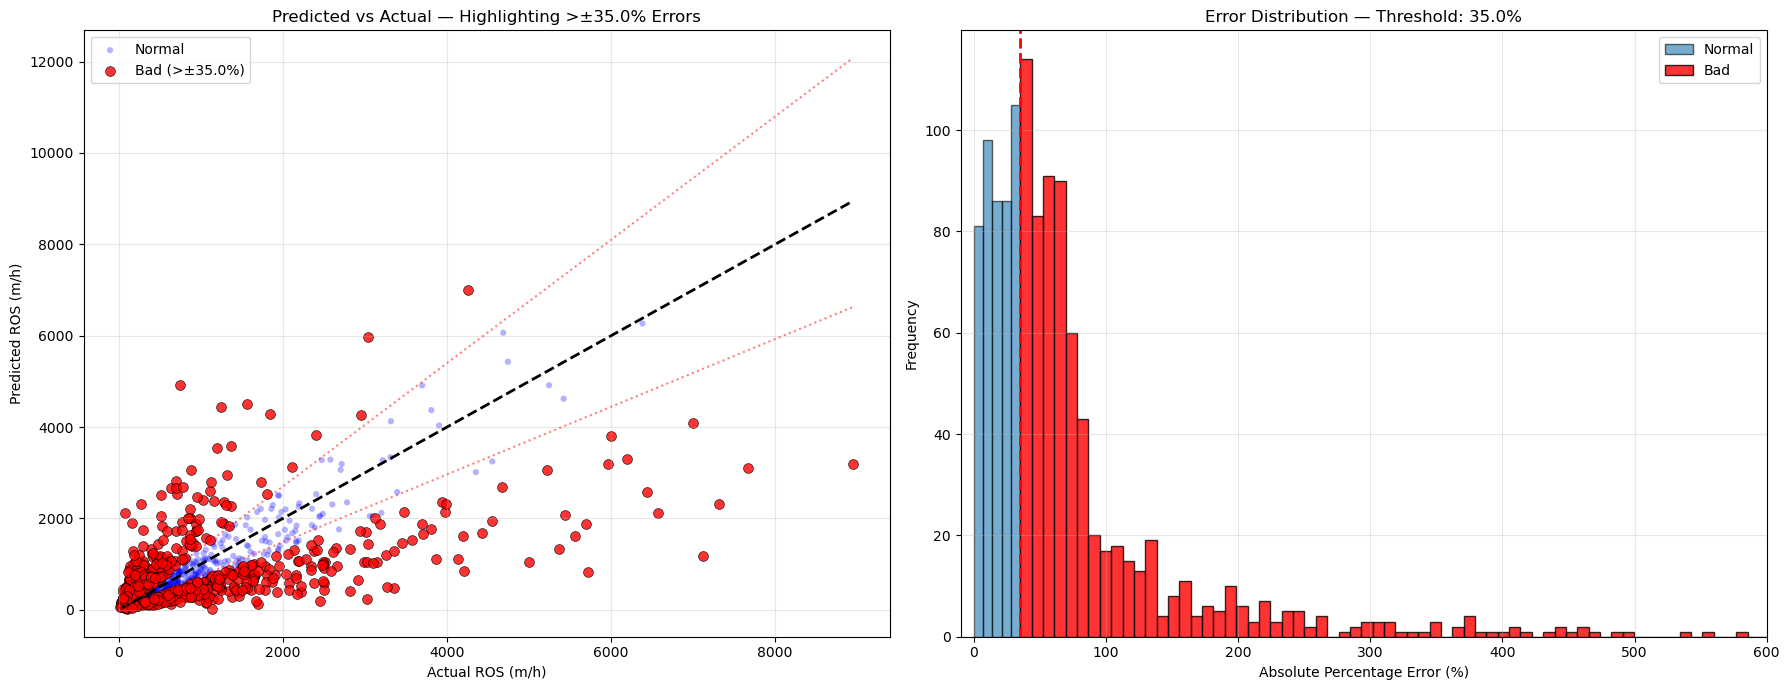

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()


In [36]:
# ============================================================
# SHAP + PREDIÇÕES CV + MERGE COM SHAPEFILE (escala linear)
# ============================================================

import shap
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Configurações de CV
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42

rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# Variáveis e target
X_shap = X_final.copy()
y_shap = y_final.copy()

# DataFrame para armazenar resultados
shap_results = pd.DataFrame(index=X_shap.index, columns=[
    'ros_p_log','ros_p_linear','PredROS_log','PredROS_linear',
    'PredDiff','Err_pct','Error_p_abs'
])
shap_values_all = pd.DataFrame(index=X_shap.index, columns=final_features)

# ------------------------------------------------------------
# 2. Repeated CV para previsões
# ------------------------------------------------------------
print("🔄 Calculando PredROS com Repeated CV e SHAP...")

for train_idx, test_idx in tqdm(rkf.split(X_shap), total=n_splits*n_repeats):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    model_cv = pipeline.fit(X_train, y_train)
    y_pred_test = model_cv.predict(X_test)

    # armazenar previsões log
    shap_results.loc[X_test.index, 'PredROS_log'] = y_pred_test
    shap_results.loc[X_test.index, 'ros_p_log'] = y_test

# ------------------------------------------------------------
# 3. Converter para escala linear (safe log)
# ------------------------------------------------------------
def safe_log_inverse(x_log):
    return np.sign(x_log) * (np.exp(np.abs(x_log)) - 1)

shap_results['PredROS_linear'] = safe_log_inverse(pd.to_numeric(shap_results['PredROS_log'], errors='coerce').fillna(0))
shap_results['ros_p_linear'] = safe_log_inverse(pd.to_numeric(shap_results['ros_p_log'], errors='coerce').fillna(0))

# métricas derivadas
mean_predros = shap_results['PredROS_linear'].mean()
shap_results['PredDiff'] = shap_results['PredROS_linear'] - mean_predros
shap_results['Err_pct'] = (shap_results['PredROS_linear'] - shap_results['ros_p_linear']) / shap_results['ros_p_linear']
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()

# =============================
# 3.1 — Marcar previsões ruins
# =============================
threshold = 0.35  # 35%
shap_results['bad_pred'] = shap_results['Error_p_abs'] > threshold

# ------------------------------------------------------------
# 4. Calcular SHAP values
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para todas as features...")
explainer = shap.LinearExplainer(final_model.named_steps["linreg"], X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_shap)
shap_values_df = pd.DataFrame(shap_values, columns=final_features, index=X_shap.index)

# ------------------------------------------------------------
# Merge vetorizado com gdf preservando geometria (sem duplicados)
# ------------------------------------------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)  # GeoDataFrame original

# Reset index para concatenar corretamente
shap_results_reset = shap_results.reset_index(drop=True)
shap_values_reset = shap_values_df.reset_index(drop=True)

# Prefixar as colunas do shap_results e shap_values para evitar duplicatas
shap_results_reset = shap_results_reset.add_prefix('model_')
shap_values_reset = shap_values_reset.add_prefix('shap_')

# Concatenar: gdf + shap_results + shap_values
merged_gdf_gpd = pd.concat([gdf, shap_results_reset, shap_values_reset], axis=1)

# Criar GeoDataFrame (preservando geometria)
merged_gdf_gpd = gpd.GeoDataFrame(merged_gdf_gpd, geometry='geometry', crs=gdf.crs)

# ------------------------------------------------------------
# Salvar shapefile e CSV
# ------------------------------------------------------------
out_shapefile = r"..\..\Data\Models\PT_FireProg_model_SHAP_Linear.shp"
merged_gdf_gpd.to_file(out_shapefile)
print(f"\n✅ SHAP + PredROS + geometria + features salvo em shapefile: {out_shapefile}")

out_csv = r"..\..\Data\Models\PT_FireProg_model_SHAP_Linear.csv"
merged_gdf_gpd.drop(columns='geometry').to_csv(out_csv, index=False)
print(f"\n✅ SHAP + PredROS + features salvo também em CSV: {out_csv}")


🔄 Calculando PredROS com Repeated CV e SHAP...


100%|██████████| 50/50 [00:00<00:00, 207.47it/s]


🔹 Calculando SHAP values para todas as features...

✅ SHAP + PredROS + geometria + features salvo em shapefile: ..\..\Data\Models\PT_FireProg_model_SHAP_Linear.shp

✅ SHAP + PredROS + features salvo também em CSV: ..\..\Data\Models\PT_FireProg_model_SHAP_Linear.csv


# benchmark 

Intercept (ln(a)): 6.2373938726650735
Coeficientes:
  wv10_kh_av_log: 0.2983
  dfmc_av: -0.3143
  FFMC_12h_a: -0.0346

R² = 0.1933
MAE = 0.7786


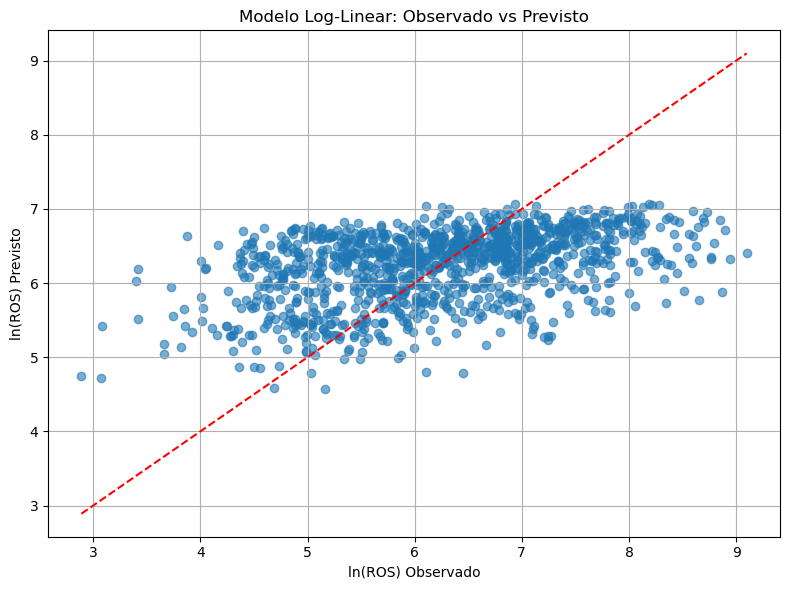


✅ Modelo salvo em 'model_benchmark.pkl'


In [37]:
# ============================================================
# MODELO LOG-LINEAR ROS ~ wv10_log + dfmc + LFMC
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# ------------------------------------------------------------
# 1. Selecionar variáveis
# ------------------------------------------------------------
X_model = X[["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]]  # ajuste se nomes diferentes
y_model = y  # ln(ROS), já log-transformado

# ------------------------------------------------------------
# 2. Criar pipeline
# ------------------------------------------------------------
pipeline_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# ------------------------------------------------------------
# 3. Treinar modelo
# ------------------------------------------------------------
pipeline_model.fit(X_model, y_model)

# ------------------------------------------------------------
# 4. Coeficientes e intercepto
# ------------------------------------------------------------
coef = pipeline_model.named_steps["linreg"].coef_
intercept = pipeline_model.named_steps["linreg"].intercept_

print("Intercept (ln(a)):", intercept)
print("Coeficientes:")
for var, c in zip(X_model.columns, coef):
    print(f"  {var}: {c:.4f}")

# ------------------------------------------------------------
# 5. Avaliar métricas
# ------------------------------------------------------------
y_pred = pipeline_model.predict(X_model)
r2 = r2_score(y_model, y_pred)
mae = mean_absolute_error(y_model, y_pred)
print(f"\nR² = {r2:.4f}")
print(f"MAE = {mae:.4f}")

# ------------------------------------------------------------
# 6. Plot ROS observado vs previsto
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_model, y_pred, alpha=0.6)
plt.plot([y_model.min(), y_model.max()], [y_model.min(), y_model.max()], "r--")
plt.xlabel("ln(ROS) Observado")
plt.ylabel("ln(ROS) Previsto")
plt.title("Modelo Log-Linear: Observado vs Previsto")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7. Salvar modelo em arquivo .pkl
# ------------------------------------------------------------
with open(r"..\..\Data\Models\model_benchmark.pkl", "wb") as f:
    pickle.dump(pipeline_model, f)

print("\n✅ Modelo salvo em 'model_benchmark.pkl'")

In [38]:
# ============================================================
# SHAP + PREDIÇÕES CV + MERGE COM SHAPEFILE (log-linear ROS)
# ============================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Selecionar variáveis e target
# ------------------------------------------------------------
X_shap = X[["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]].copy()
y_shap = y.copy()  # ln(ROS)

final_features = X_shap.columns.tolist()

# ------------------------------------------------------------
# 2. Configurações de CV
# ------------------------------------------------------------
n_splits = 10
n_repeats = 5
random_state = 42
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# Pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# DataFrames para armazenar resultados
shap_results = pd.DataFrame(index=X_shap.index, columns=[
    'ros_p_log','ros_p_linear','PredROS_log','PredROS_linear',
    'PredDiff','Err_pct','Error_p_abs'
])
shap_values_all = pd.DataFrame(index=X_shap.index, columns=final_features)

# ------------------------------------------------------------
# 3. Repeated CV para previsões
# ------------------------------------------------------------
print("🔄 Calculando PredROS com Repeated CV...")

for train_idx, test_idx in tqdm(rkf.split(X_shap), total=n_splits*n_repeats):
    X_train, X_test = X_shap.iloc[train_idx], X_shap.iloc[test_idx]
    y_train, y_test = y_shap.iloc[train_idx], y_shap.iloc[test_idx]

    model_cv = pipeline.fit(X_train, y_train)
    y_pred_test = model_cv.predict(X_test)

    # armazenar previsões log
    shap_results.loc[X_test.index, 'PredROS_log'] = y_pred_test
    shap_results.loc[X_test.index, 'ros_p_log'] = y_test

# =============================
# 3.1 — Marcar previsões ruins
# =============================
threshold = 0.35  # 35%
shap_results['bad_pred'] = shap_results['Error_p_abs'] > threshold

# ------------------------------------------------------------
# 4. Converter para escala linear (safe log)
# ------------------------------------------------------------
def safe_log_inverse(x_log):
    return np.sign(x_log) * (np.exp(np.abs(x_log)) - 1)

shap_results['PredROS_linear'] = safe_log_inverse(pd.to_numeric(shap_results['PredROS_log'], errors='coerce').fillna(0))
shap_results['ros_p_linear'] = safe_log_inverse(pd.to_numeric(shap_results['ros_p_log'], errors='coerce').fillna(0))

# métricas derivadas
mean_predros = shap_results['PredROS_linear'].mean()
shap_results['PredDiff'] = shap_results['PredROS_linear'] - mean_predros
shap_results['Err_pct'] = (shap_results['PredROS_linear'] - shap_results['ros_p_linear']) / shap_results['ros_p_linear']
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()

# ------------------------------------------------------------
# 5. Calcular SHAP values
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para todas as features...")
explainer = shap.LinearExplainer(pipeline.named_steps["linreg"], X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_shap)
shap_values_df = pd.DataFrame(shap_values, columns=final_features, index=X_shap.index)

# ------------------------------------------------------------
# 6. Merge vetorizado com gdf preservando geometria
# ------------------------------------------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)  # GeoDataFrame original

# Reset index para concatenar corretamente
shap_results_reset = shap_results.reset_index(drop=True)
shap_values_reset = shap_values_df.reset_index(drop=True)

# Prefixar colunas para evitar duplicatas
shap_results_reset = shap_results_reset.add_prefix('model_')
shap_values_reset = shap_values_reset.add_prefix('shap_')

# Concatenar: gdf + shap_results + shap_values
merged_gdf_gpd = pd.concat([gdf, shap_results_reset, shap_values_reset], axis=1)
merged_gdf_gpd = gpd.GeoDataFrame(merged_gdf_gpd, geometry='geometry', crs=gdf.crs)

# ------------------------------------------------------------
# 7. Salvar shapefile e CSV
# ------------------------------------------------------------
out_shapefile = r"..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.shp"
merged_gdf_gpd.to_file(out_shapefile)
print(f"\n✅ SHAP + PredROS + geometria + features salvo em shapefile: {out_shapefile}")

out_csv = r"..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.csv"
merged_gdf_gpd.drop(columns='geometry').to_csv(out_csv, index=False)
print(f"\n✅ SHAP + PredROS + features salvo também em CSV: {out_csv}")


🔄 Calculando PredROS com Repeated CV...


100%|██████████| 50/50 [00:00<00:00, 233.64it/s]


🔹 Calculando SHAP values para todas as features...

✅ SHAP + PredROS + geometria + features salvo em shapefile: ..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.shp

✅ SHAP + PredROS + features salvo também em CSV: ..\..\Data\Models\PT_FireProg_model_SHAP_Benchmark.csv


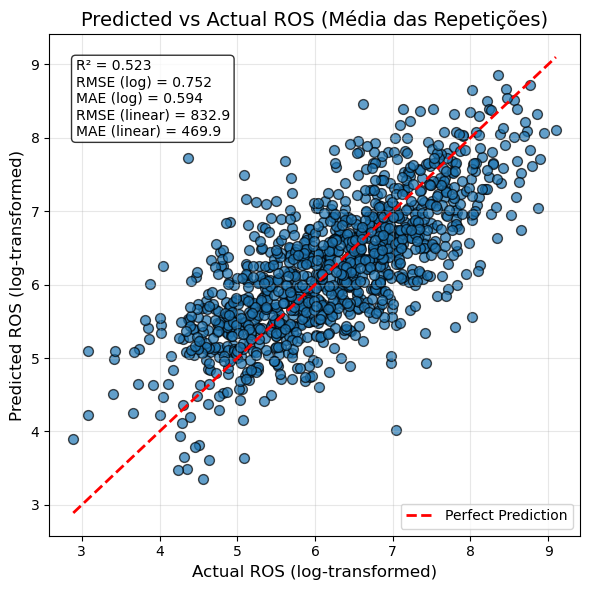

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ============================================================
# 1. Acumular previsões de cada fold para cada observação
# ============================================================
pred_matrix = np.full((len(y), rkf.get_n_splits()), np.nan)

for fold_idx, (train_idx, test_idx) in enumerate(rkf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_pred = pipeline.fit(X_train, y_train).predict(X_test)
    pred_matrix[test_idx, fold_idx] = y_pred

# Média das previsões
avg_pred_log = np.nanmean(pred_matrix, axis=1)
avg_actual_log = y.values

# ============================================================
# 2. Função para reverter log
# ============================================================
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

# ============================================================
# 3. Métricas
# ============================================================
r2_avg = r2_score(avg_actual_log, avg_pred_log)
mae_log_avg = mean_absolute_error(avg_actual_log, avg_pred_log)
rmse_log_avg = np.sqrt(mean_squared_error(avg_actual_log, avg_pred_log))

y_actual_linear = inverse_safe_log(avg_actual_log)
y_pred_linear = inverse_safe_log(avg_pred_log)
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))

# ============================================================
# 4. Scatter plot Predicted vs Actual
# ============================================================
plt.figure(figsize=(6, 6))
plt.scatter(avg_actual_log, avg_pred_log, alpha=0.7, edgecolor='k', s=50)

min_val = min(avg_actual_log.min(), avg_pred_log.min())
max_val = max(avg_actual_log.max(), avg_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Média das Repetições)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f'R² = {r2_avg:.3f}\n'
    f'RMSE (log) = {rmse_log_avg:.3f}\n'
    f'MAE (log) = {mae_log_avg:.3f}\n'
    f'RMSE (linear) = {rmse_linear_avg:.1f}\n'
    f'MAE (linear) = {mae_linear_avg:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


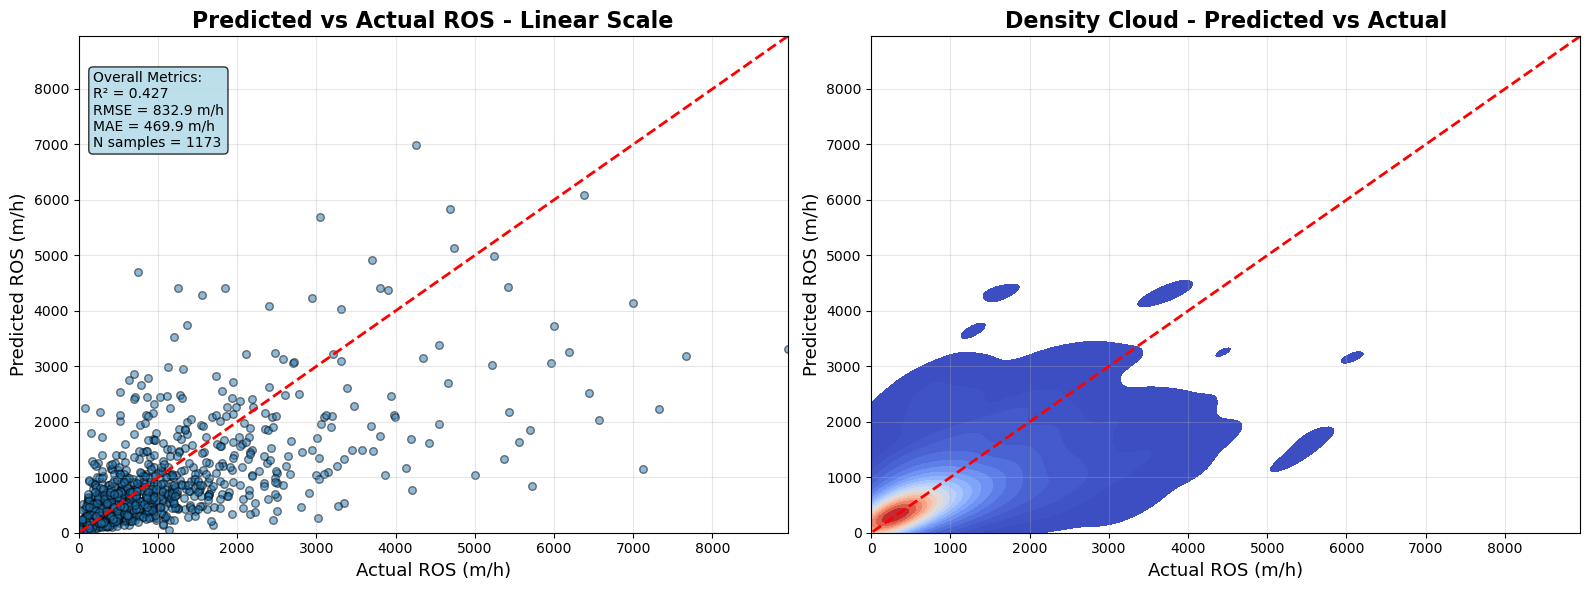

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# 1. Converter de log → linear
# ============================================================
y_actual_linear = inverse_safe_log(avg_actual_log)
y_pred_linear = inverse_safe_log(avg_pred_log)

# ============================================================
# 2. Métricas lineares
# ============================================================
r2_linear = r2_score(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)

# ============================================================
# 3. Scatter + 2D KDE plot
# ============================================================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# -------------------------
# Left panel: Scatter plot
# -------------------------
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

metrics_text = (
    f'Overall Metrics:\n'
    f'R² = {r2_linear:.3f}\n'
    f'RMSE = {rmse_linear_avg:.1f} m/h\n'
    f'MAE = {mae_linear_avg:.1f} m/h\n'
    f'N samples = {len(y_actual_linear)}'
)
ax1.text(
    0.02, 0.93, metrics_text,
    transform=ax1.transAxes, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10
)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# -------------------------
# Right panel: 2D KDE density plot
# -------------------------
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


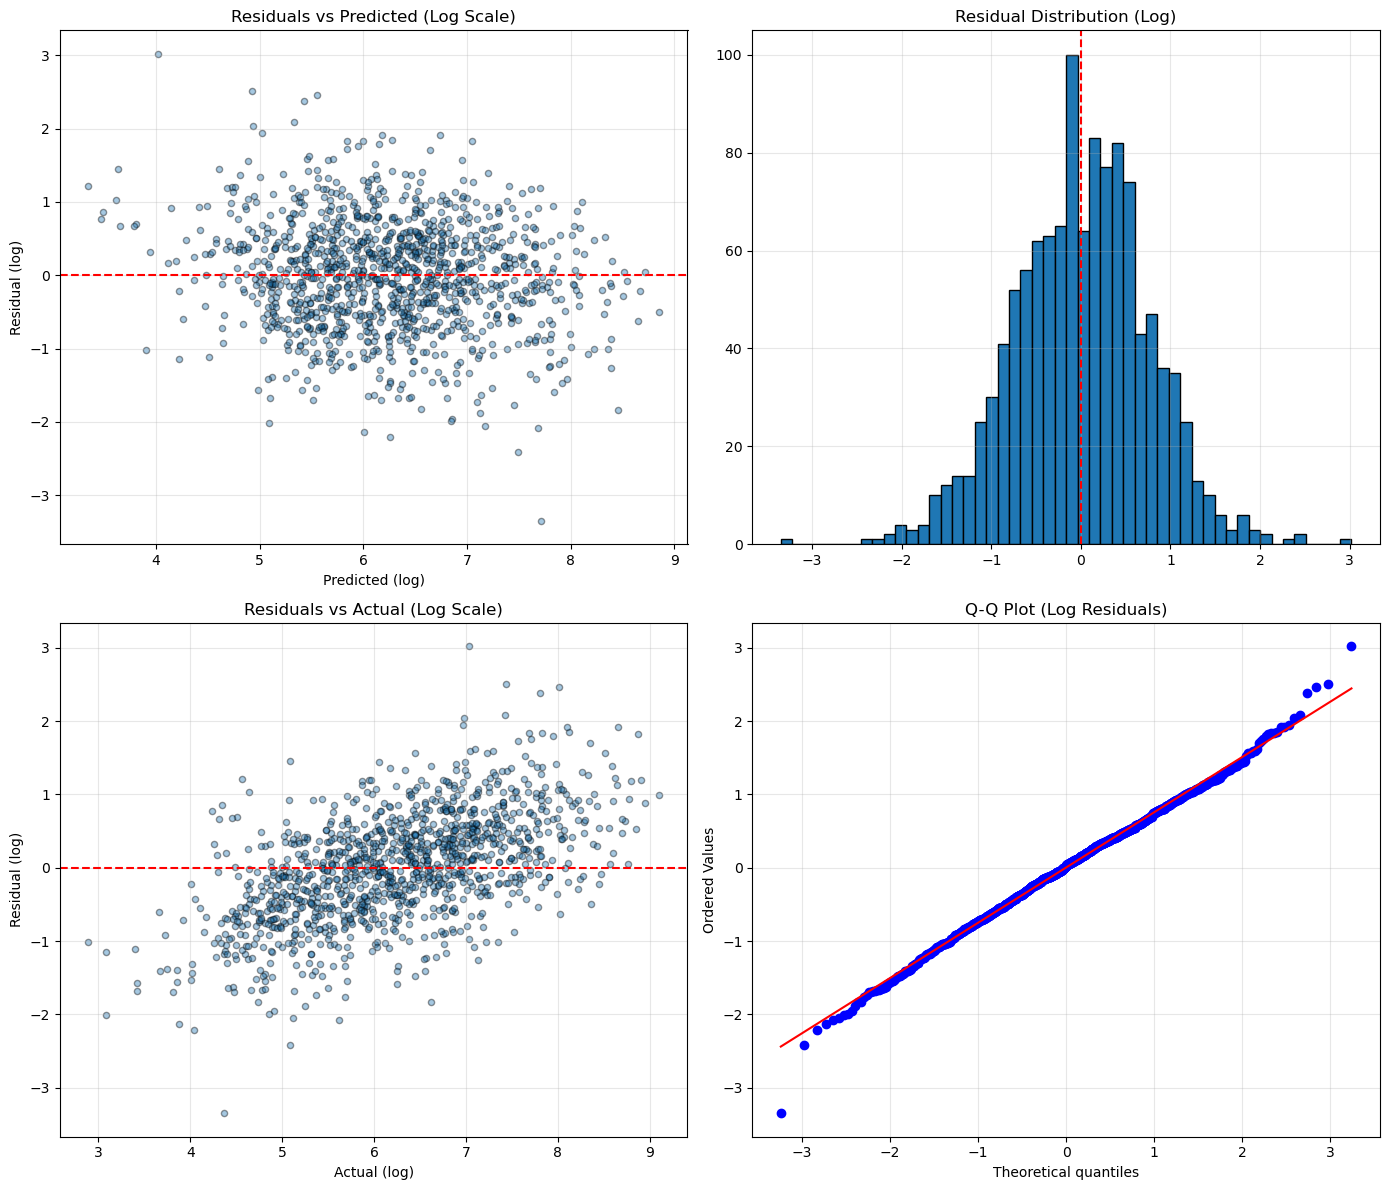

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# ============================================================
# 1. Usar médias do Repeated K-Fold
# ============================================================
avg_actual = avg_actual_log   # valores reais médios (log)
avg_pred   = avg_pred_log     # valores previstos médios (log)

# Conversão para escala linear, se quiser usar depois
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos na escala log
residuals_log = avg_actual - avg_pred

# ============================================================
# 2. Plots de diagnóstico dos resíduos
# ============================================================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------
# Residuals vs Predicted
# -------------------------
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# -------------------------
# Histogram of residuals
# -------------------------
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# -------------------------
# Residuals vs Actual
# -------------------------
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# -------------------------
# Q-Q Plot
# -------------------------
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


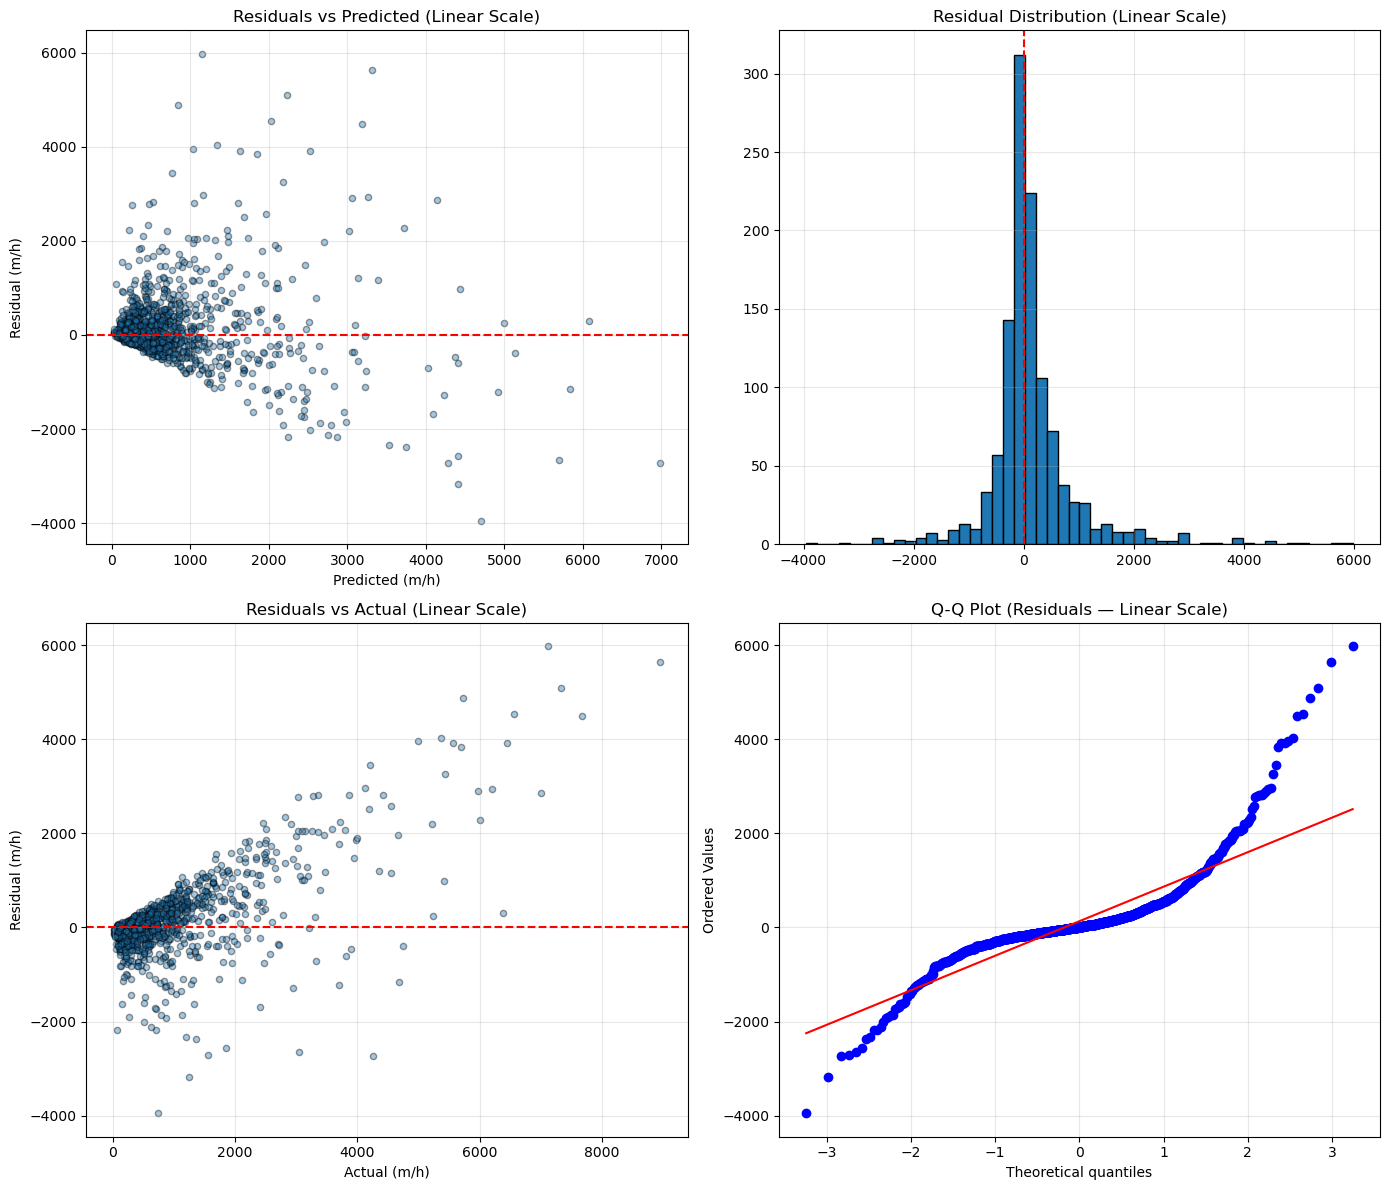

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = avg_actual_log      # já calculado antes
avg_pred_log   = avg_pred_log        # já calculado antes

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 456  (38.9%)
Bad Predictions  : 717  (61.1%)


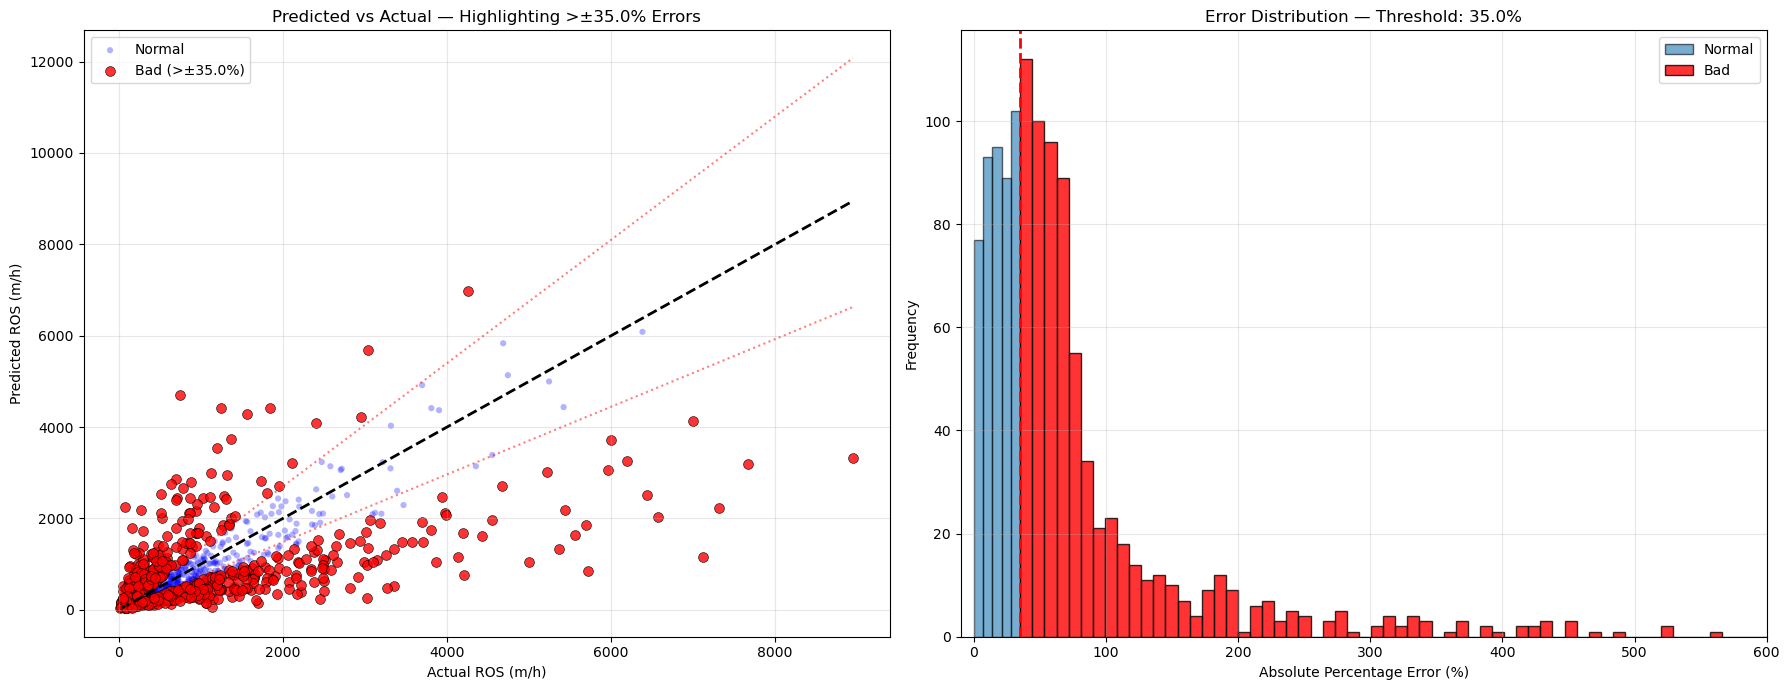

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()
